In [9]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel, RunnableBranch, RunnableLambda
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel,Field
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [5]:
from langgraph.graph.message import add_messages
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages] 
    

In [6]:
llm  = ChatOpenAI()
def chat_node(state: ChatState):
    # take user query from state
    messages = state['messages']
    
    # send to llm
    response = llm.invoke(messages)
    
    # response store state in list
    return {'messages':[response]}

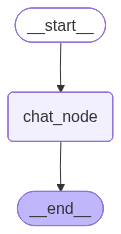

In [10]:
checkpointer = MemorySaver()
graph = StateGraph(ChatState)
# add nodes
graph.add_node('chat_node',chat_node)
graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node',END)

chatbot = graph.compile(checkpointer=checkpointer)
chatbot


In [ ]:
initial_state = {
    'messages': [HumanMessage(content='What is the Capital of india')]
}

chatbot.invoke(initial_state)['message'][-1].content

In [ ]:
thread_id = '1'

while True:
    user_message = input('Type here: ')
    if user_message.strip().lower() in ['exit','quit','bye']:
        break
    config = {'configurable':{'thread_id': thread_id}}
    response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]},config=config)
    print('AI: ', response['messages'][-1].content)